# Projet 3: Concevez une application au service de la santé publique

Open Food Facts est une association à but non lucratif composée de volontaires qui fournit une base de données de produits alimentaires qui répertorie les ingrédients, les allergènes, la composition nutritionnelle et toutes les informations présentes sur les étiquettes des aliments. 

Toute la base de données est publiée sous forme de données ouvertes (open data) qui peuvent être utilisées par tous et pour tous usages.

La base de données contient:
- des **informations générales**: code barre du produit, url du produit sur le site d'Open Food Facts, contributeur qui a ajouté le produit pour la première fois, date de l'ajout et de la modification d'un produit, le nom du produit, sa quantité, son image
- des informations sur le **type du produit**: marque, catégorie, label
- des informations sur sa **provenance**: origine, lieu de transformation, pays,villes et magasins où sont proposés les produits
- des informations sur le type d'**emballage** du produit
- des informations sur la **composition** du produit: ingrédients, additifs, allergènes, nutriments, vitamines
- des **scores**: empreinte carbonne, nutriscore (défini par la FSA et sa version adaptée au marché français), grade de nutrition (de A à E)

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :
- en **nutriments et aliments à favoriser** (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en **nutriments à limiter** (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Visualisation et chargement du dataset](#dataset)
3. [Mots qui apparaissent le plus souvent dans le nom des variables](#words)
    1. [_100g](#100g)
    2. [_tags](#tags)
    3. [_en](#en)
    4. [_url / image](#url)
    5. [_ingredients](#ingredients)
    6. [_packaging](#packaging)
    7. [_name](#name)
    8. [_places](#places)
    9. [_additives](#additives)
    10. [Autres variables](#misc)
5. [Sélection de variables pertinentes en lien avec le choix d'application](#selec_var)
6. [Doublons](#doublons)
7. [Gestion des valeurs aberrantes](#outliers)
8. [Gestion des valeurs manquantes](#nan)    

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np # pour l'algèbre linéaire
import pandas as pd # pour l'analyse de données
import collections # pour compter l'occurence de mots
from collections import Counter

import seaborn as sns # datavisualisation
import matplotlib.pyplot as plt # datavisualisation
from matplotlib.gridspec import GridSpec # visualisation sous forme de grille
from wordcloud import WordCloud # nuage de mots

In [2]:
#plt.rcParams.keys()

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')

## Visualisation et chargement du dataset <a class="anchor" id="dataset"></a>

In [5]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t')

Lorsque l'on tente de charger directement le dataset, on obtient une erreur indiquant l'index des colonnes posant problème (type mixte). Afin de récupérer le nom des variables pour leur affecter un dtypes avant import, nous allons charger uniquement les 5 premières lignes et récupérer les colonnes (0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66):

In [6]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', nrows = 5)
#openfoodfacts

In [7]:
#liste_colonnes_pour_dtypes = [0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66]
#print(openfoodfacts.iloc[:,liste_colonnes_pour_dtypes].columns.tolist())

In [8]:
# Certaines colonnes ont des modalités de type différent, forçons le type en object
dtypes = {
    'code':object, 
    'abbreviated_product_name':object, 
    'packaging_text':object, 
    'origins':object,
    'origins_tags':object, 
    'origins_en':object, 
    'manufacturing_places':object,
    'manufacturing_places_tags':object, 
    'emb_codes':object, 
    'emb_codes_tags':object,
    'first_packaging_code_geo':object, 
    'cities_tags':object,
    'purchase_places':object,
    'allergens':object,
    'traces':object,
    'traces_tags':object, 
    'traces_en':object, 
    'ingredients_from_palm_oil_tags':object, 
    'ingredients_that_may_be_from_palm_oil_tags':object, 
    'brand_owner':object, 
    'ecoscore_grade_fr':object
}

In [9]:
# Chargement du dataset avec les bons dtypes
openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', dtype=dtypes)

Nous allons créer une fonction qui permettra de savoir si lors d'un import futur, les variables correspondent à celles chargées à l'origine. Si ce n'est pas le cas, il faudra analyser les nouvelles variables afin de définir si elles apportent une information supplémentaire et peut être adapter le script.

In [10]:
#print(openfoodfacts.columns.tolist())

In [11]:
def controle_des_colonnes(dataset):
    '''Fonction qui permet de vérifier que toutes les colonnes ont bien été importées parmi la liste des variables 
    importées lors de la phase de cleaning'''
    
    liste_colonnes = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                      'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 
                      'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 
                      'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 
                      'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 
                      'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 
                      'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 
                      'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 
                      'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 
                      'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 
                      'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                      'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 
                      'states', 'states_tags', 'states_en', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 
                      'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 
                      'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kj_100g', 
                      'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 
                      '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', 
                      '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', 
                      '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', 
                      '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                      'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', 
                      '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', 
                      '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 
                      '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', 
                      '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 
                      'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', 
                      '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 
                      'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 
                      'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 
                      'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 
                      'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 
                      'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 
                      'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 
                      'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 
                      'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 
                      'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 
                      'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 
                      'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 
                      'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 
                      'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 
                      'inositol_100g', 'carnitine_100g']
    
    
    if dataset.columns.tolist() == liste_colonnes:
        print('Toutes les variables ont bien été chargées')
    
    else:
        print('Variable(s) non présente(s) dans le dataset:')
        print(set(liste_colonnes) - set(dataset.columns.tolist()))
        
        print('Variable(s) supplémentaires dans le dataset:')
        print(set(dataset.columns.tolist()) - set(liste_colonnes))

In [12]:
controle_des_colonnes(openfoodfacts)

Toutes les variables ont bien été chargées


In [13]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.9+ GB


In [14]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnata...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Regardons à présent le nombre de lignes et colonnes du dataset.

In [15]:
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 187


Supprimons les variables composées à 100% de valeurs manquantes qui n'apportent aucune information et viennent alourdir le dataset.

In [16]:
# Liste des colonnes avec 100% de NaN
print([c for c in openfoodfacts.columns if (openfoodfacts[c].isnull().mean()*100 == 100)])

['cities', 'allergens_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g']


In [17]:
# Suppression les colonnes avec 100% de données manquantes
openfoodfacts.dropna(how='all', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 148


In [18]:
def missing_values_all(dataframe):
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f'Nombre total de NaN du dataset: {missing} \n % total de NaN du dataset: {missing_percent}%')

In [19]:
missing_values_all(openfoodfacts)

Nombre total de NaN du dataset: 227465052 
 % total de NaN du dataset: 74.84%


## Mots qui apparaissent le plus souvent dans le nom des variables <a class="anchor" id="words"></a>

Dans un premier temps et afin de prendre connaissance avec les variables du jeu de données, récupérons les mots contenus dans le titre des variables qui reviennent le plus souvent.
Cette étape nous permettra de repérer une potentielle redondance entre les variables.

In [20]:
# Récupération des mots contenus dans les titres des colonnes (séparateur =  "_")
liste_mots_colonnes = [i.split('_') for i in openfoodfacts.columns] 

# Applatissement de la liste de listes
liste_mots_colonnes_flat = []

for item in liste_mots_colonnes:
    liste_mots_colonnes_flat += item

In [21]:
# J'affiche les 20 mots qui reviennent le plus dans les titres de colonnes
print(collections.Counter(liste_mots_colonnes_flat).most_common(20))

# J'enregistre tous les mots et le nombre associé dans une variable
most_common_columns_words = collections.Counter(liste_mots_colonnes_flat).most_common(len(liste_mots_colonnes_flat))

[('100g', 79), ('tags', 14), ('en', 8), ('url', 7), ('ingredients', 7), ('image', 6), ('packaging', 4), ('from', 4), ('palm', 4), ('oil', 4), ('name', 3), ('categories', 3), ('origins', 3), ('places', 3), ('labels', 3), ('countries', 3), ('traces', 3), ('additives', 3), ('n', 3), ('states', 3)]


In [22]:
# Passage sous dataframe afin de pouvoir visualiser les données sous forme de graphique (nb occurences >= 6)
most_common_columns_words = pd.DataFrame(most_common_columns_words, 
                                 columns = ['Mots', 'Nombre d\'occurences']).sort_values(by = 'Nombre d\'occurences', 
                                                                                         ascending=False)

most_common_columns_words = most_common_columns_words[most_common_columns_words["Nombre d\'occurences"] >= 6]

In [23]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

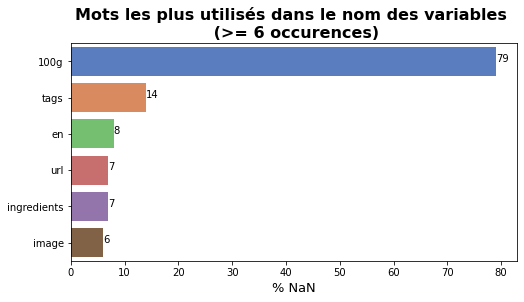

In [24]:
# Visualisation sous forme de barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(y = 'Mots', x = 'Nombre d\'occurences', data = most_common_columns_words, palette = 'muted')
plt.title("Mots les plus utilisés dans le nom des variables \n (>= 6 occurences)")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax);

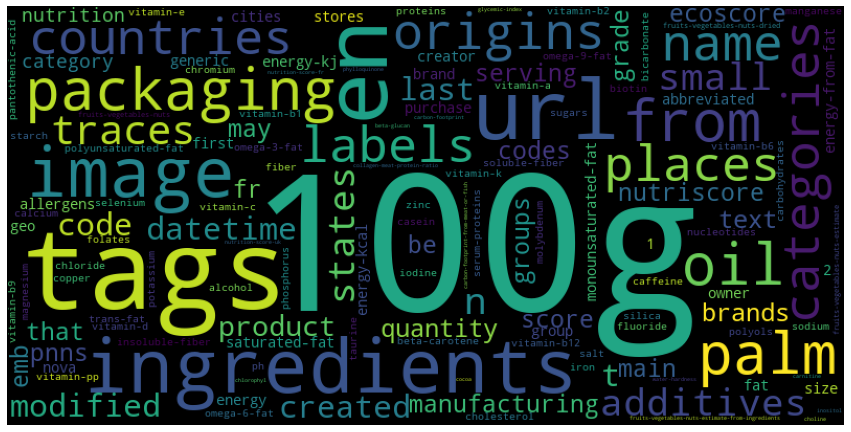

In [25]:
# Création d'un nuage de mots

# Conversion de la liste en dictionnaire valeurs / occurences
word_cloud_dict = Counter(liste_mots_colonnes_flat)
wordcloud = WordCloud(width = 800, height = 400).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off");

### 100g <a class="anchor" id="100g"></a>

Les variables qui se terminent par _100g correspondent à la quantité de nutriments (en g ou kj pour l'énergie) pour 100g ou 100 ml de produit. Logiquement ces variables devraient être de type float.

In [26]:
# Liste des colonnes qui se terminent par _100g
col_100g = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].columns.tolist()
print(col_100g)

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'sele

In [27]:
# On downcast les variables en float32 pour réduire la mémoire
for col in col_100g:
    openfoodfacts[col] = openfoodfacts[col].astype('float32')

In [28]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 148 entries, code to carnitine_100g
dtypes: float32(79), float64(7), int64(2), object(60)
memory usage: 1.7+ GB


In [29]:
# Dtypes des variables qui se terminent par _100g et qui ne sont pas de type float
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_100g)].select_dtypes(exclude = ['float32']).dtypes

Series([], dtype: object)

Toutes ces variables sont bien au format float. En regardant la liste des colonnes, on peut se demander si les variables energy-kj_100g et energy_100g apportent la même information.

In [30]:
openfoodfacts[openfoodfacts[['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].notnull().all(1)][
    ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].head()

,energy-kj_100g,energy-kcal_100g,energy_100g
4,685.799988,163.899994,685.799988
417,2318.000000,561.000000,2318.000000
419,1104.000000,268.000000,1104.000000
790,442.000000,1852.000000,442.000000
863,1926.000000,460.000000,1926.000000


Les colonnes energy-kj_100g et energy_100g semblent être redondantes. Regardons la proportion de NaN.

In [31]:
print(f"% de NaN de la variable energy-kj_100g: {round(openfoodfacts['energy-kj_100g'].isna().mean(),4)*100}%")
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy-kj_100g: 92.7%
% de NaN de la variable energy_100g: 20.66%


La variables energy_100g comporte bien moins de valeurs manquantes que energy-kj_100g. Nous allons remplir les NaN de energy_100g avec les éventuelles  valeurs renseignées de energy-kj_100g puis supprimer la colonne energy-kj_100g.

In [32]:
# Pour les NaN de energy_100g, je complète avec energy-kj_100g sinon je laisse tel quel
openfoodfacts['energy_100g'] = np.where(openfoodfacts['energy_100g'].isnull(), 
                                        openfoodfacts['energy-kj_100g'], 
                                        openfoodfacts['energy_100g'])

In [33]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 20.66%


La variable energy-kj_100g ne semble pas avoir diminué le taux de NaN de energy_100g, nous pouvons la supprimer.

In [34]:
openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')
openfoodfacts.shape

<ipython-input-34-112d0e192dab>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')


(2053679, 147)

### tags <a class="anchor" id="tags"></a>

Les variables qui se terminent par _tags sont des variables qualitatives (packaging, marques, catégories etc). Elles doivent être de type "object".

In [35]:
# Liste des colonnes qui se terminent par _tags
col_tags = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_tags')].columns.tolist()
print(col_tags)

['packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'cities_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_tags']


In [36]:
# On cast les variables en str
for col in col_tags:
    openfoodfacts[col] = openfoodfacts[col].astype("object")

In [37]:
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_tags)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

Toutes ces variables ont bien le dtype objet. A partir du préfixe des variables se terminant par _tags, tentons de récupérer les variables associées afin de s'assurer qu'elles ne sont pas redondantes. 

In [38]:
# Pour chaque colonne se terminant par _tags, je supprime cette mention pour n'avoir que le préfixe
liste_col_tags_prefixe = [i.replace('_tags', '') for i in openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(col_tags)].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _tags: {liste_col_tags_prefixe}')

Préfixes des colonnes se terminant par _tags: ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'cities', 'countries', 'traces', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'states']


In [39]:
# Fusion des 2 listes + tri par ordre alphabétique
liste_col_tags = liste_col_tags_prefixe + col_tags
liste_col_tags.sort()

In [40]:
print(f'Colonnes + colonnes associées _tags:\n\n {liste_col_tags}')

Colonnes + colonnes associées _tags:

 ['additives', 'additives_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'countries', 'countries_tags', 'emb_codes', 'emb_codes_tags', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'labels', 'labels_tags', 'manufacturing_places', 'manufacturing_places_tags', 'origins', 'origins_tags', 'packaging', 'packaging_tags', 'states', 'states_tags', 'traces', 'traces_tags']


Automatisation des étapes précédentes.

In [41]:
def liste_col_endswith(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_ends_keyword = dataframe.iloc[:,(dataframe.columns.str.endswith(
    keyword))].columns.unique().tolist()
    
    liste_col_keyword = liste_col_keyword_prefixe + liste_col_ends_keyword
    liste_col_keyword.sort()
    
    return liste_col_keyword

In [42]:
liste_col_tags = liste_col_endswith(openfoodfacts, 'tags')

In [43]:
def describe_variables_light(data):
    '''Fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count, 
                                      percent_count,missing, percent_missing]], 
                                    columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                               '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN']))
        
    return df.reset_index(drop = True)

In [44]:
describe_variables_light(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging,object,"barquette,plastique",2053679,57066,2.78,315935,15.38,1737744,84.62
1,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
2,brands,object,endives,2053679,183520,8.94,1050597,51.16,1003082,48.84
3,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85
4,categories,object,"Epicerie, Condiments, Sauces, Moutardes",2053679,117610,5.73,945149,46.02,1108530,53.98
5,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
6,origins,object,Spain,2053679,14023,0.68,88290,4.30,1965389,95.70
7,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
8,manufacturing_places,object,bénivay-ollon,2053679,28901,1.41,128424,6.25,1925255,93.75
9,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75


In [45]:
def completion_distinct_plots(data):
    ''' fonction qui prend un dataframe en entrée et retourne 2 diagrammes en barres représentant le pourcentage 
    de données manquantes et le pourcentage de données distinctes du dataset. Cette fonction nécessite que
    soit chargée auparavant la fonction describe_variables '''   
    
    # Initialisation de la grille avec 1 ligne et 2 colonnes
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, figure=fig)

    # Premier graphique
    ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
    ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables_light(data), palette = 'muted')
    plt.title("% NaN")
    plt.ylabel("")
    plt.xlabel("% NaN")
    etiquette_h(ax1)
        

# Deuxième graphique
    ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
    ax2 = sns.barplot(y = 'Variable name', x = '% distinct', data = describe_variables_light(data), palette = 'muted')
    plt.title("% valeurs distinctes")
    plt.ylabel("")
    plt.xlabel("% distinct")
    etiquette_h(ax2);

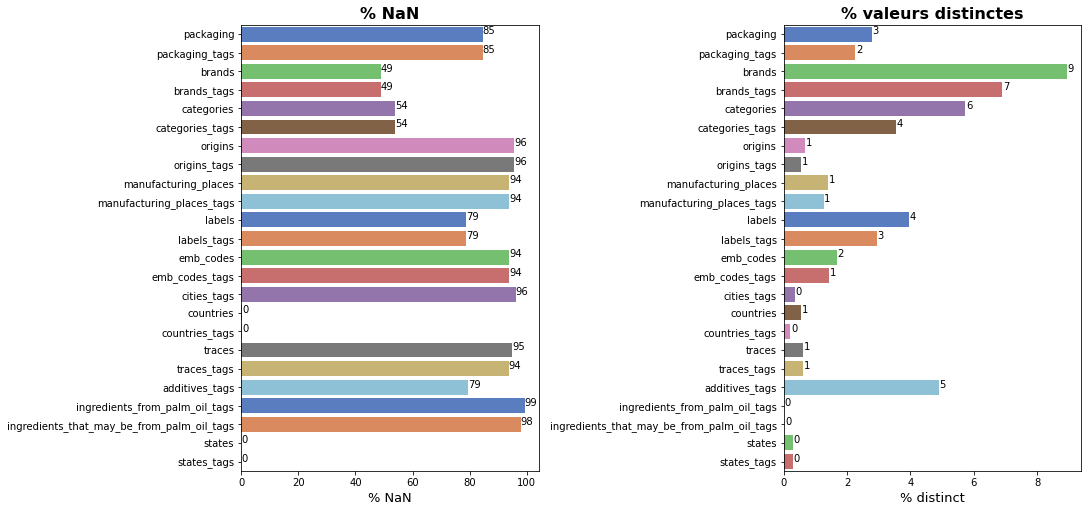

In [46]:
completion_distinct_plots(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

Nous remarquons que les variables se terminant par _tags comportent souvent le même % de NaN que la variable associée mais le % de valeurs distinctes est quant à lui inférieur. Il semble être plus intéressant de conserver les variables se terminant par _tags et de supprimer les variables associées afin d'éviter la redondance d'information. De plus le site openfoodfacts nous indique que les variables _tags sont normalisées. Regardons quelques exemples avant de supprimer toutes les variables associées à celles se terminant par _tags.

In [47]:
openfoodfacts[~openfoodfacts['brands'].isnull()][['brands', 'brands_tags']].sample(10)

,brands,brands_tags
1055089,Leclerc,leclerc
779046,Jean Caby,jean-caby
553653,Les Délices des 7 Vallées,les-delices-des-7-vallees
497332,Justin's,justin-s
863458,Ederki,ederki
823125,Cora,cora
1111471,Baguette Paillasse,baguette-paillasse
499679,Redhawk Food Group Inc.,redhawk-food-group-inc
1399050,Delhaize,delhaize
673105,Merevale,merevale


In [48]:
openfoodfacts[~openfoodfacts['categories'].isnull()][['categories', 'categories_tags']].sample(10)

,categories,categories_tags
209127,"Groceries, Sauces","en:groceries,en:sauces"
651061,"Alimentos y bebidas de origen vegetal, Bebidas...","en:plant-based-foods-and-beverages,en:beverage..."
241261,Biscuits and cakes,en:biscuits-and-cakes
1231876,"Dairies, Fermented foods, Fermented milk produ...","en:dairies,en:fermented-foods,en:fermented-mil..."
594379,"Dairies,Fermented foods,Fermented milk product...","en:dairies,en:fermented-foods,en:fermented-mil..."
903856,"Plats préparés, Pizzas tartes salées et quiche...","en:meals,en:pizzas-pies-and-quiches,en:quiches..."
1003698,Pâtes à pizza,en:pizza-dough
811630,fr:jambons-crus,"en:meats,en:prepared-meats,en:hams,en:cured-ham"
41860,"Dairies, Fermented foods, Fermented milk produ...","en:dairies,en:fermented-foods,en:fermented-mil..."
498211,"Snacks, Sweet snacks, Confectioneries, Chocola...","en:snacks,en:sweet-snacks,en:cocoa-and-its-pro..."


In [49]:
openfoodfacts[~openfoodfacts['labels'].isnull()][['labels', 'labels_tags']].sample(10)

,labels,labels_tags
1109749,"Bio, Bio européen, Agriculture UE/Non UE, FR-B...","en:organic,en:eu-organic,en:non-eu-agriculture..."
803785,en:nutriscore-grade-e,"en:nutriscore,en:nutriscore-grade-e"
1430827,en:organic,en:organic
1255926,"Organic, de:Bio 7 Initiative, en:de-oko-001","en:organic,en:eu-organic,de:bio-7-initiative,e..."
1632072,en:palm-oil-free,en:no-palm-oil
812431,"en:FSC, FSC Mix, Point Vert, Sans sucre ajouté...","en:fsc,en:fsc-mix,en:green-dot,en:no-added-sug..."
1470264,PL-EKO-02,"en:organic,en:eu-organic,en:pl-eko-02"
630288,"Viande Française, Viande Porcine Française, Sa...","en:french-meat,en:french-pork,en:no-colorings"
1823922,"Sin gluten,Contiene una fuente de fenilalanina","en:no-gluten,en:contains-a-source-of-phenylala..."
1806503,en:es-eco-019-ct,"en:organic,en:eu-organic,en:es-eco-019-ct"


Les variables semblent bien redondantes entre elles. Nous remarquons également que les variables se terminant par _tags semblent être le plus souvent traduites en anglais. Nous décidons de garder ces dernières.

In [50]:
liste_col_suppr = openfoodfacts.iloc[:,(openfoodfacts.columns.isin(liste_col_tags)) & 
                                        (~openfoodfacts.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'countries', 'traces', 'states']


In [51]:
# Suppression des variables sans suffixe _tags
openfoodfacts_tags = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 137


### en <a class="anchor" id="en"></a>

La documentation nous indique que ces variables sont la traduction des variables _tags dans la langue indiquée. Elles doivent être de type "object".

In [52]:
# Liste des colonnes qui se terminent par _en
col_en = openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.str.endswith('_en')].columns.tolist()
print(col_en)

['categories_en', 'origins_en', 'labels_en', 'countries_en', 'traces_en', 'additives_en', 'states_en', 'main_category_en']


In [53]:
# On cast les variables en str
for col in col_en:
    openfoodfacts_tags[col] = openfoodfacts_tags[col].astype("object")

In [54]:
openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(col_en)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

In [55]:
print(liste_col_endswith(openfoodfacts_tags, 'en'))

['additives', 'additives_en', 'categories', 'categories_en', 'countries', 'countries_en', 'labels', 'labels_en', 'main_category', 'main_category_en', 'origins', 'origins_en', 'states', 'states_en', 'traces', 'traces_en']


On retrouve dans cette liste les préfixes des variables qui se terminent par _tags. Lorsque l'on applique la fonction précédente on ne récupère que le préfixe et la variable associée. Il faudrait en fait récupérer tous les préfixes et regarder les variables associées: _tags, _en etc. Améliorons la fonction.

In [56]:
def liste_col_prefixe(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_select = dataframe.iloc[:, dataframe.columns.str.startswith(
        tuple(liste_col_keyword_prefixe))].columns.unique().tolist()
    
    liste_col_select.sort()
                                      
    return dataframe.iloc[:,dataframe.columns.isin(liste_col_select)].columns

In [57]:
liste_col_en = liste_col_prefixe(openfoodfacts_tags, 'en')

In [58]:
describe_variables_light(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
1,categories_en,object,"Groceries,Condiments,Sauces,Mustards",2053679,72800,3.54,945141,46.02,1108538,53.98
2,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
3,origins_en,object,Spain,2053679,11389,0.55,88160,4.29,1965519,95.71
4,labels_tags,object,fr:delois-france,2053679,60380,2.94,438458,21.35,1615221,78.65
5,labels_en,object,fr:delois-france,2053679,60362,2.94,438458,21.35,1615221,78.65
6,countries_tags,object,en:france,2053679,4403,0.21,2047488,99.70,6191,0.30
7,countries_en,object,France,2053679,4403,0.21,2047488,99.70,6191,0.30
8,traces_tags,object,"en:eggs,en:milk",2053679,12766,0.62,129529,6.31,1924150,93.69
9,traces_en,object,"Eggs,Milk",2053679,12766,0.62,129529,6.31,1924150,93.69


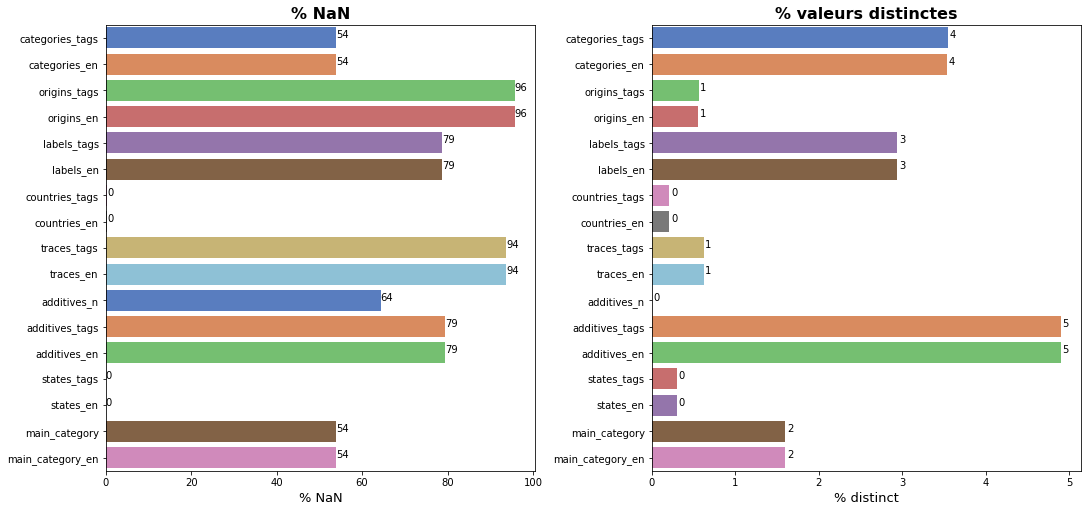

In [59]:
completion_distinct_plots(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

Nous remarquons que les variables ayant le même préfixe comportent le même % de NaN et de valeurs distinctes. Comme nous avons déjà précedemment supprimé les variables sans suffixe, il nous reste les variables se terminant par _tags et _en. Nous avons donc le choix de conserver soit l'une soit l'autre. Vérifions juste un exemple avant de choisir quelles variables supprimer.

In [60]:
openfoodfacts_tags[~openfoodfacts_tags['categories_tags'].isnull()][['categories_tags', 'categories_en']].sample(10)

,categories_tags,categories_en
1832539,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
26488,en:desserts,Desserts
27124,"en:groceries,en:condiments","Groceries,Condiments"
856466,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product..."
1498503,en:brick-sheets,Brick sheets
62265,en:snacks,Snacks
1172915,de:butterschmalz,de:butterschmalz
54470,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product..."
150437,"en:groceries,en:sauces,en:dips","Groceries,Sauces,Dips"
1228175,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."


Les modalités étant plus lisibles et harmonisées dans les colonnes se terminant par _en, supprimons les colonnes _tags.

In [61]:
liste_col_suppr = openfoodfacts_tags.iloc[:,(openfoodfacts_tags.columns.isin(liste_col_en)) & 
                                        (openfoodfacts_tags.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['categories_tags', 'origins_tags', 'labels_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'states_tags']


In [62]:
# Suppression des variables avec suffixe _tags
openfoodfacts_en = openfoodfacts_tags.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 130


### url / image  <a class="anchor" id="url"></a>

Ces variables indiquent les urls et les images des produits et n'apportent aucune information. Supprimons les.

In [63]:
liste_col_url = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains('url|image')].columns.unique().tolist()
print(f"Liste des variables url à supprimer: \n\n {liste_col_url}")

Liste des variables url à supprimer: 

 ['url', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']


In [64]:
# Suppression des variables contenant les mot url ou image
openfoodfacts_en.drop(liste_col_url, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 123


### ingredients <a class="anchor" id="ingredients"></a>

In [65]:
def check_redundancy(dataframe, keyword):
    ''' Fonction qui renseigne sur les principales statistiques des variables contenant le mot saisi en entrée.'''
    liste = dataframe.iloc[:,dataframe.columns.str.contains(keyword)].columns.unique().tolist()
    describe = describe_variables_light(dataframe[liste])
    return describe

In [66]:
def modalities_no_NaN(dataframe, keyword):
    ''' Fonction qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    liste_col = check_redundancy(dataframe, keyword)['Variable name'].tolist()
    return dataframe[dataframe[liste_col].notnull().all(1)][liste_col].sample(5)

<div class="alert alert-block alert-info">
    <p> Pas sûre de ma fonction: j'aimerais retourner 2 dataframes directement en appliquant la fonction plutôt que d'affecter la fonction à tab_desc, tab_modalities et de les afficher séparemment. Est-ce possible? </p>
</div>

In [67]:
def check_redundancy_steps(dataframe, mot_clef):
    ''' Fonction qui renvoie 2 dataframes: 
    tab_desc qui renseigne sur les principales  statistiques des variables contenant le mot saisi en entrée
    tab_modalities qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    tab_desc = check_redundancy(dataframe, mot_clef)
    tab_modalities = modalities_no_NaN(dataframe, mot_clef)
    return tab_desc, tab_modalities

In [68]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'ingredients')

In [69]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ingredients_text,object,"Leche semidesnatada, azucar 6.9% leche desnata...",2053679,616705,30.03,732671,35.68,1321008,64.32
1,ingredients_from_palm_oil_n,float64,0.0,2053679,4,0.00,732673,35.68,1321006,64.32
2,ingredients_from_palm_oil_tags,object,huile-de-palme,2053679,16,0.00,14505,0.71,2039174,99.29
3,ingredients_that_may_be_from_palm_oil_n,float64,0.0,2053679,7,0.00,732673,35.68,1321006,64.32
4,ingredients_that_may_be_from_palm_oil_tags,object,"e481-stearoyl-2-lactylate-de-sodium,e472e-este...",2053679,350,0.02,43295,2.11,2010384,97.89
5,fruits-vegetables-nuts-estimate-from-ingredien...,float32,0.0,2053679,7644,0.37,731230,35.61,1322449,64.39


In [70]:
tab_modalities

,ingredients_text,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,fruits-vegetables-nuts-estimate-from-ingredients_100g
1407163,"Farine de _blé_, graisse de palme, huile de na...",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,0.000000
787939,"Farine de Hé- Crème de pruneau 25% (pruneau, s...",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,8.333333
1422723,"Lait écrémé réhydraté, matières grasses végéta...",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,0.000000
1184346,"Farine de _blé_, raisins secs 27% , huile de p...",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,27.000000
759950,"Pépites de chocolat 23 % (sucre, pâte de cacao...",1.0,huile-de-palme,2.0,e471-mono-et-diglycerides-d-acides-gras-alimen...,0.000000


Nous pouvons remarquer que la variable ingredients_text contient un grand nombre de modalités et 64.32% de valeurs manquantes. 

Nous pouvons également voir que 4 variables comportent la mention palm_oil dont 2 variables qui se terminent par _n indiquent le nombre d'ingrédients contenant de l'huile de palme. 

Les 2 variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags ont un pourcentage très élevé de valeurs manquantes et semblent redondantes avec les variables numériques, qui si supérieures à 0, indiquent la présence d'huile de palme ou assimilé. Nous décidons de les supprimer.

In [71]:
# Suppression des variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags
openfoodfacts_en.drop(['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags'],
                        axis = 'columns',
                        inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 121


### packaging <a class="anchor" id="packaging"></a>

Ces variables ne seront pas utilisées par la suite, supprimons les:

In [72]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'packaging')

In [73]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
1,packaging_text,object,1 pot en verre à recycler,2053679,4306,0.21,8240,0.40,2045439,99.60
2,first_packaging_code_geo,object,"47.833333,-0.333333",2053679,3768,0.18,73908,3.60,1979771,96.40


In [74]:
tab_modalities

,packaging_tags,packaging_text,first_packaging_code_geo
1024051,"frais,plastique",1 barquette plastique à jeter,"47.766667,-3.233333"
808738,surgele,1 Carton à recycler 1 Film plastique à jeter,"43.366667,-1.266667"
684323,"carton,pots-en-plastique,fr-etui-en-carton,fr-...","Étui en carton : 20,25 g. Opercule papier : 0,...","48.1,-0.8"
842752,"carton,plastique,fr-barquette,fr-film-en-plast...",1 barquette plastique PP transparent à jeter 1...,"45.033333,5.05"
1221350,conserve,Boîte Métal à recycler,"44.166667,4.883333"


In [75]:
# Suppression des variables contenant le mot packaging
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 118


### name <a class="anchor" id="name"></a>

In [76]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'name')

In [77]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,product_name,object,jeunes pousses,2053679,1276058,62.14,1970360,95.94,83319,4.06
1,abbreviated_product_name,object,Amora Moutarde Strong 6x2.5Kg 1x,2053679,7073,0.34,7197,0.35,2046482,99.65
2,generic_name,object,Blanquette de Volaille et son Riz,2053679,89427,4.35,123512,6.01,1930167,93.99


In [78]:
tab_modalities

,product_name,abbreviated_product_name,generic_name
730754,4 Pains burger géant à la farine complète,Burger Géant Cplt Ss Add x4 JACQUET,Pain spécial pour hamburger à la farine complète
948704,Saucisson sec tranches fines -25% de sel,Coch son tsr vpf 32t 100g c6p,Saucisson sec supérieur pur porc
764608,Bénénuts 3D's Bugles goût cacahuète format fam...,3d's bugles gout cacahuetes 150g,Produit soufflé à base de maïs goût cacahuète
747677,Légumiô - Haricots Rouges et Tomates en Pipe R...,Légumiô H ROUG TOMA PIPE RIGAT 250G,Spécialité de haricots rouges et tomates
971565,Saucisses Déliss' Original,Deliss'original familial 700g,Deliss'original familial 700g


Ces trois variables nous apportent la même information. abbreviated_product_name et generic_name ayant un fort pourcentage de valeurs manquantes, nous décidons de supprimer ces 2 variables.

In [79]:
# Suppression des variables abbreviated_product_name et generic_name
openfoodfacts_en.drop(['abbreviated_product_name', 'generic_name'], axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 116


### places <a class="anchor" id="places"></a>

In [80]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'places')

In [81]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75
1,purchase_places,object,France,2053679,11361,0.55,161431,7.86,1892248,92.14


In [82]:
tab_modalities

,manufacturing_places_tags,purchase_places
853106,france,France
1231570,"dettingen-teck,deutschland","Wiesbaden,Deutschland"
1255748,deutschland,Deutschland
1553227,allemagne,Suisse
891336,"france,47200-virazeil",Paris


Ces variables étant très peu alimentées (plus de 90% de NaN), supprimons les.

In [83]:
# Suppression des variables
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 114


### additives <a class="anchor" id="additives"></a>

In [84]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'additives')

In [85]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,additives_n,float64,0.0,2053679,40,0.0,732673,35.68,1321006,64.32
1,additives_en,object,"E296 - Malic acid,E330 - Citric acid,E552 - Ca...",2053679,100577,4.9,423384,20.62,1630295,79.38


In [86]:
tab_modalities

,additives_n,additives_en
223780,2.0,"E150c - Ammonia caramel,E322 - Lecithins,E322i..."
801078,2.0,"E412 - Guar gum,E415 - Xanthan gum"
1338152,10.0,"E14XX - Modified Starch,E150d - Sulphite ammon..."
441730,7.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E12..."
451837,1.0,E412 - Guar gum


Le pourcentage de valeurs manquantes étant "acceptable", nous décidons de conserver ces variables pour le moment.

### Autres variables  <a class="anchor" id="misc"></a>

La nomenclature des variables nous donne d'autres informations. Elle se trouve à l'adresse: https://static.openfoodfacts.org/data/data-fields.txt

#### Dates

In [87]:
# Colonnes dont le titre se termine par "_t" ou "_datetime"
print("Liste des variables dont le titre se termine par _t ou _datetime: ")
liste_col_date = openfoodfacts_en.iloc[:,(openfoodfacts_en.columns.str.endswith('_datetime')) |
                   (openfoodfacts_en.columns.str.endswith('_t'))].columns.tolist()
liste_col_date

Liste des variables dont le titre se termine par _t ou _datetime: 


['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']

In [88]:
# Passage au bon format
from datetime import datetime
import time

for column in liste_col_date:
    if column.endswith('_t'):
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], unit='s')
    else:
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], format="%Y-%m-%d %H:%M:%S.%f", utc=True)

In [89]:
openfoodfacts_en[liste_col_date].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,2021-06-16 14:53:28,2021-06-16 14:53:28+00:00,2021-06-16 14:53:29,2021-06-16 14:53:29+00:00
1,2021-09-01 08:11:51,2021-09-01 08:11:51+00:00,2021-09-01 08:14:24,2021-09-01 08:14:24+00:00
2,2018-06-15 10:38:00,2018-06-15 10:38:00+00:00,2019-06-25 11:55:18,2019-06-25 11:55:18+00:00
3,2018-10-13 21:06:14,2018-10-13 21:06:14+00:00,2018-10-13 21:06:57,2018-10-13 21:06:57+00:00
4,2019-11-19 15:02:16,2019-11-19 15:02:16+00:00,2021-06-22 19:39:25,2021-06-22 19:39:25+00:00


On remarque de la redondance d'information, on supprime les variables qui se terminent par _datetime puis nous créons des variables Année pour l'analyse future.

In [90]:
# Suppression des variables redondantes
openfoodfacts_en.drop(['created_datetime', 'last_modified_datetime'], axis=1, inplace = True)

In [91]:
# On renomme les variables de date
openfoodfacts_en.rename(columns={'created_t': 'creation_date', 
                              'last_modified_t': 'last_modified_date'}, inplace = True)

In [92]:
# On créé des variables "Année"
openfoodfacts_en['creation_year'] = pd.to_datetime(openfoodfacts_en['creation_date'], format='%d:%m:%Y').dt.year
openfoodfacts_en['last_modified_year'] = pd.to_datetime(openfoodfacts_en['last_modified_date'], format='%d:%m:%Y').dt.year

In [93]:
# On décale les colonnes "Année" après les colonnes de date:
colonne_a_decaler = openfoodfacts_en.pop('creation_year') 
openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("creation_date")+1, 'creation_year', colonne_a_decaler) 

colonne_a_decaler = openfoodfacts_en.pop('last_modified_year') 
openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("last_modified_date")+1, 'last_modified_year', colonne_a_decaler) 

In [94]:
openfoodfacts_en.dtypes[0:10]

code                          object
creator                       object
creation_date         datetime64[ns]
creation_year                  int64
last_modified_date    datetime64[ns]
last_modified_year             int64
product_name                  object
quantity                      object
brands_tags                   object
categories_en                 object
dtype: object

#### serving_ 

Les variables qui commencent par serving_ correspondent au nombre de nutriments (en g, ou kj pour l'énergie) pour une part du produit. Elles doivent être de type numérique.

In [95]:
liste_col_serving = openfoodfacts_en.iloc[:,
                                            openfoodfacts_en.columns.str.
                                            startswith('serving_'
                                                       )].columns.unique(
                                                       ).tolist()

print(f"Liste des variables commençant par serving: \n\n {liste_col_serving}")

Liste des variables commençant par serving: 

 ['serving_size', 'serving_quantity']


In [96]:
# Exemples de variables contenant serving_ sans données manquantes
openfoodfacts_en[openfoodfacts_en[liste_col_serving].notnull().all(1)][liste_col_serving].sample(5)

,serving_size,serving_quantity
40309,19 g,19.0
434186,3 PIECES (33 g),33.0
519137,8 OZA (240 ml),240.0
298369,1 BOTTLE (474 ml),474.0
519489,1 ONZ (28 g),28.0


Ces 2 colonnes semblent être redondantes, vérifions le % de NaN

In [97]:
describe_variables_light(openfoodfacts_en[liste_col_serving])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,serving_size,object,serving,2053679,47101,2.29,509794,24.82,1543885,75.18
1,serving_quantity,float64,28.0,2053679,2456,0.12,505560,24.62,1548119,75.38


Le % de NaN étant assez similaire et la variable serving_quantity déjà au format numérique, supprimons la variable serving_size.

In [98]:
# Suppression de la variable serving_size
openfoodfacts_en.drop('serving_size', axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 113


<div class="alert alert-block alert-warning">
    <p> Suppression de variables pour libérer de la RAM </p>
</div>

## Sélection de variables pertinentes en lien avec le choix d'application <a class="anchor" id="selec_var"></a>

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Je souhaite y contribuer en proposant **une nouvelle signalétique permettant aux femmes enceintes de s'assurer que le produit ne contient pas d'aliment proscrit pendant la grossesse et de proposer une alternative avec le meilleur nutriscore si le produit sélectionné ne convient pas**.

Je me suis basée sur le guide nutrition de la grossesse dont les données proviennent de l'Agence française de sécurité sanitaire des aliments (AFSSA) disponibles en téléchargement sur le site de Santé Publique France à cette adresse: https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/documents/brochure/le-guide-nutrition-de-la-grossesse

On y retrouve les vitamines et oligoéléments essentiels pendant la grossesse tels que: 
- les **folates** (vitamine B9) pour le développement du système nerveux de l'embryon 
- le **calcium** (construction du squelette de l'enfant)
- la **viatmine D** qui permet à l'organisme à mieux absorber le calcium des aliments
- le **fer**
- l'**iode** (fonctionnement de la glande thyroïde + développement cerveau de l'enfant)


Certains aliments sont à proscrire pendant la grossesse ou à manger en petite quantité. Parmis eux: 
- le **soja**
- **certains poissons**: anguille, barbeau, brème, carpe, silure, lotte, bar, bonite, empereur, grenadier, flétan, brochet, dorade, raie, sabre, thon, espadon, marlin, siki, requin, lamproie
- les boissons contenant de la **caféine**
- le foie et les **produits à base de foie**
- les **fromages à pâte molle à croûte fleurie** (type camembert, brie) et à **croûte lavée** (type munster, pont- l’évêque), surtout s’ils sont au lait cru ; les **fromages râpés industriels**
- certains produits de charcuterie, notamment **rillettes, pâtés, foie gras, produits en gelée**
- la **viande crue** ou peu cuite, le **poisson cru** (sushi, sashimi, tarama), les **poissons fumés** (saumon, truite),et les **crustacés décortiqués vendus cuits**
- les produits enrichis en **phytostérols**
- l'**alcool**

Nous allons donc filtrer le dataset sur les variables qui nous apportent de l'information sur les éléments ci-dessus. Notre application aura pour cible les femmes enceintes qui achètent en France. Il est en effet obligatoire de traduire les étiquettes dans la langue où le produit est vendu ce qui facilitera l'analyse. Cette application pourrait être adaptée à différents pays ultérieurement.

In [99]:
# Copie du dataset
openfoodfacts_light = openfoodfacts_en.copy()

### Vitamines et oligoéléments  <a class="anchor" id="vitamines"></a>

In [100]:
# Modalités de la variable countries_en
print(openfoodfacts_light['countries_en'].unique().tolist()[0:60])

['France', 'Spain', 'United States', 'Ireland', nan, 'Belgium', 'United Kingdom', 'France,United States', "Côte d'Ivoire", 'Canada', 'Switzerland', 'Italy', 'Germany', 'Belgium,France', 'Peru', 'Oman', 'Slovenia', 'France,Germany', 'France,Germany,Netherlands', 'Kuwait', 'United Arab Emirates', 'France,Switzerland', 'India', 'Romania', 'Australia', 'Norway', 'Luxembourg', 'Portugal', 'Mexico', 'Dominican Republic', 'Réunion', 'Israel', 'Netherlands', 'Saudi Arabia', 'Poland', 'Germany,United States', 'Germany,Ireland', 'Rwanda', 'France,United Kingdom', 'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe', 'Chile', 'Thailand', 'El Salvador', 'Algeria', 'Greece', 'Spain,Switzerland', 'France,Russia', 'France,India', 'Austria,Frankreich,Spanien', 'Senegal', 'United Kingdom,United States', 'Andorra', 'Austria,France', 'Luxembourg,Deutschland,Spanien', 'Lithuania', 'Germany,Spain', 'Russia', 'Panama', 'Jersey']


Nous avions vu précédement que la variable countries_en ne possède que 0.30% de NaN, nous allons donc sélectionner uniquement les lignes où cette variable est remplie (na = False). Nous remarquons également qu'un produit peut être vendu dans plusieurs pays et que parfois le pays France est traduit dans une autre langue.

In [ ]:
liste_pays_FR = ['France', 'FR', 'en:FR', 'en:fr', 'en:France', 'Frankreich', 
              'france', 'Réunion', 'Francia', 'French Polynesia', 'Frankrijk', 
              'Nouvelle-Calédonie', 'Martinique', 'Guadeloupe', 
              'Polynésie Française', 'Mayotte']

In [ ]:
# Filtre des données sur le Country 'France'
openfoodfacts_France = openfoodfacts_light[openfoodfacts_light['countries_en'] == ]

In [ ]:
openfoodfacts_light[openfoodfacts_light['countries_en'].isin(liste_pays)]

In [ ]:
openfoodfacts_light[openfoodfacts_light['countries_en'].str.contains('fran', na = False)]['countries_en'].unique()

In [ ]:
openfoodfacts_en['countries_en'].unique().tolist()

In [ ]:
openfoodfacts_en.columns.tolist()

Les nutriments sont des variables distinctes dans le dataset. Nous allons filtrer ce dernier sur les nutriments essentiels traduits en anglais.

In [116]:
# Liste des nutriments essentiels
liste_nutriments_essentiels = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains(
    'folates|vitamin-b9|calcium|vitamin-d|iron|iodine|alcohol')].columns.tolist()

Les aliments à proscrire sont des modalités de la variable

In [ ]:
# Liste des aliments à proscrire

In [121]:
openfoodfacts_en[openfoodfacts_en['ingredients_text'].str.contains(
    'soja|caféine|foie|phytostérols', na = False)][['product_name', 'ingredients_text', 'countries_en']]

,product_name,ingredients_text,countries_en
468,Preparation mug cake chocolat-caramel au beurr...,"farine de blé (gluten), sucre de canne, pépite...",France
476,Colorant alimentaire bleu velours en spray,"VELOURS EN S RAY dessert, passé préalableme Bi...",France
497,Preparation biscuits cacao/noisette,"farine de riz, sucre, amidon de maïs, cacao (4...",France
499,Chocolat lait noisette,FR - CHOCOLAT LAIT (40% min. caéao) AVEC NOISE...,France
581,mini doony's chocolat x8,"farine: BLE, SOJA huiles et graisses vegetales...",France
...,...,...,...
2047642,Les Estivales Mangue Passion,"Mangue (28 %), eau, sucre, _amandes_, sirop de...",France
2047764,Truffe de noix de pécan,"Noix de pécan, sucre, lait entier en poudre, p...",France
2048255,Mini stollen,"45 % massepain (44% amandes, sucre, sirop de g...",France
2048258,Saumon à l'oseille,'1/1/1/ Riz basmati accompagné d'une sauce à l...,France


In [118]:
openfoodfacts_en[openfoodfacts_en['ingredients_text'].str.contains(
    'soya|soja|caféine|caffeine|foie|liver|phytostérols|phytosterols', na = False)][['product_name', 'ingredients_text']]

,product_name,ingredients_text
6,hyde icon,"beta alanine, creatine hcl, ancient peat & app..."
295,"M&S Extrenely Chocolatey Milk, Dark & White Ch...","milk chocolate (32%) (sugar, cocoa butter, dri..."
468,Preparation mug cake chocolat-caramel au beurr...,"farine de blé (gluten), sucre de canne, pépite..."
476,Colorant alimentaire bleu velours en spray,"VELOURS EN S RAY dessert, passé préalableme Bi..."
497,Preparation biscuits cacao/noisette,"farine de riz, sucre, amidon de maïs, cacao (4..."
...,...,...
2047642,Les Estivales Mangue Passion,"Mangue (28 %), eau, sucre, _amandes_, sirop de..."
2047764,Truffe de noix de pécan,"Noix de pécan, sucre, lait entier en poudre, p..."
2048255,Mini stollen,"45 % massepain (44% amandes, sucre, sirop de g..."
2048258,Saumon à l'oseille,'1/1/1/ Riz basmati accompagné d'une sauce à l...


In [117]:
openfoodfacts_en[openfoodfacts_en['ingredients_text'].str.contains('phytostérols', na = False)][['product_name', 'ingredients_text']]

,product_name,ingredients_text
431611,Ekang,"Émolliente, nourrissante et protectrice. Ce j..."
1967536,Proactiv,"huiles végétales 54% (tournesol, colza, palme'..."
1968305,ProActiv - Margarine,"Eau, huiles végétales 30% (tournesol, palme, l..."
1988352,ProActiv Margarine Tartine Sans Huile de Palme...,"Eau, huiles végétales 36% (tournesol, lin, kar..."
1988353,ProActiv Margarine🧈 Tartine Sans Huile🪔 de Pal...,"Liste des ingrédients: Eau, huiles végétales 3..."
1988356,ProActiv Expert Tartine et Gourmet Sans Huile ...,"Huiles végétales 50% (colza, tournesol, karité..."
1988751,Pro active,"Eau, huiles végétales 35% (tournesol, colza, p..."


In [119]:
openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains(
    'phytosterols')].columns.tolist()

[]

In [ ]:
liste_var_categ = ['code','last_modified_date','last_modified_year','product_name', 
                   'brands_tags','categories_en','labels_en','countries_en','ingredients_text','allergens',
                   'traces_en','serving_quantity','additives_n','additives_en','nova_group','pnns_groups_1',
                   'pnns_groups_2','brand_owner','ecoscore_score_fr','ecoscore_grade_fr','main_category',
                   'main_category_en','energy-kcal_100g','energy_100g','energy-from-fat_100g','fat_100g']

liste_a_eviter =  ['caffeine_100g', 'taurine_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'sugars_100g']

, 
        

liste_nutriscore = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'nutriscore_score', 
                    'nutriscore_grade']

In [ ]:
describe_variables_light(openfoodfacts_en)

In [ ]:
liste_var_a_conserver = [,






                         

                      
                         


[Retour à la table des matières](#0)

<div class="alert alert-block alert-info">
    <p> Si on filtre sur le nom des ingrédients en français, peut être qu'il n'y a pas besoin de filtrer sur le pays </p>
</div>